## Import libraries

In [2]:
library('ggplot2')
library('gridExtra')
library(grid)
library(reshape2)
library(fitdistrplus)
library(actuar)
library(RColorBrewer)
library(scales)
library(depmixS4)

In [7]:
setwd("../")

In [8]:
getwd()

[1] "/Users/tballing/Documents/Research/GPSeq/cleaned_up_workflows"

In [3]:
figdir="./plots"

# Fitting distributions to the data

## Plotting functions

In [4]:
plot_gofstats <- function(stats){
    pdat=data.frame(fit=labels(stats$aic), AIC=stats$aic, BIC=stats$bic)
    mdat <- melt(pdat)
    p <- ggplot(data=mdat, aes(x=fit, y=value, colour=variable)) + 
    geom_point(position=position_dodge(width = 0.2)) + 
    labs(x="fitted distribution", y="", colour="Criterion")
    p <- p + theme(legend.position="right", axis.text.x=element_text(angle=30, hjust=1)) + 
        labs(title="Goodness of Fit") + 
        scale_y_continuous(labels=scientific, breaks=seq(min(mdat$value[is.finite(mdat$value)]), 
                                        max(mdat$value[is.finite(mdat$value)]), length.out=3))
    return(p)
}

make_comp_plots<- function(realcnt, mytitle="", myxlim=NULL){
    if (is.null(myxlim)){
        qnt <- quantile(realcnt, probs=c(0.25,0.5,0.75))
        iqr <- qnt[3]-qnt[1]
        myxlim <- qnt[2] + 6 *iqr
    }
    mycnts <- realcnt[realcnt < myxlim]
    l=mean(mycnts)
    n=length(mycnts)
    #fl <- fitdist(mycnts, "lnorm", method="mle")
    fnorm <- fitdist(mycnts, "norm", method="mme", discrete=T)
    fgamma <- fitdist(mycnts, "gamma", method="mme", discrete=T)
    fpois <- fitdist(mycnts, "pois", method="mme", discrete=T)
    fgeom <- fitdist(mycnts, "geom", method="mme", discrete=T)
    #fhyper <- fitdist(mycnts, "hyper", method="mme", discrete=T)
    fnbin <- fitdist(mycnts, "nbinom", method="mme", discrete=T)
    myfits = list(fnorm, fgamma, fpois, fgeom, fnbin)
    plot.legend=c("normal", "gamma", "poisson", "geometric", 
                  "negative binomial")
    stats=gofstat(myfits, fitnames=plot.legend)
    # make the fitted distribution in order of best fit and add the BIC to the legend. 
    mybic=stats$bic
    oi <- seq(length(myfits)) # don't change the order. order(stats$bic)
    myfits <- myfits[oi]
    plot.legend <- plot.legend[oi]
    mybic=stats$bic[oi]
    legendnames=plot.legend
    for (i in seq_along(myfits)){
        legendnames[i] <- paste0(plot.legend[i], " (", format(mybic[i], digits=4, scientific=TRUE), ")")
    }
    mycols=brewer.pal(length(myfits), "Set1")
    mylwd=1.5
    myxlim=c(0,myxlim)
    cp <- cdfcomp(myfits, legendtext=legendnames, fitcol=mycols, lwd=mylwd, xlim=myxlim, plotstyle="ggplot")
    cp <- cp + labs(x="umiCounts", title=mytitle) + 
        theme(plot.title=element_text(size=12))
    ps <- plot_gofstats(stats)
    return(list(cp, ps))
}

## results

In [9]:
gpsdat <- read.table("data/BICRO58_all_umiCount.txt", header=T)

In [10]:
gpsdat <- gpsdat[c(1:3,5:nrow(gpsdat)),] # remove a weird outlier point
gpsdat[1,]

chr,start,end,cs_id,TK100_5min,TK101_10min,TK102_15min,TK103_30min,TK104_on,TK99_1min
chr1,237070,237076,cs_237076,-1,-1,-1,-1,1,-1


In [11]:
myplots <- c()
for (i in c(5:10)){
    mydat <- gpsdat[,i]
    mydat[mydat< 0]=0
    p <- make_comp_plots(realcnt=mydat, mytitle=colnames(gpsdat)[i])
    pcdf <- p[[1]] + coord_cartesian(ylim=c(0.95,1))
    myplots <- c(myplots, list(pcdf))
}

Warning message:
“Ignoring unknown parameters: shape”Using fit as id variables
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Warning message:
“Ignoring unknown parameters: shape”Using fit as id variables
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Warning message:
“Ignoring unknown parameters: shape”Using fit as id variables
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Warning message:
“Ignoring unknown parameters: shape”Using fit as id variables
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Warning message:
“Ignoring unknown parameters: shape”Using fit as id variables
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Warning message:
“Ignoring unknown parameters: shape”Using fit as id variables
Coordinate syste

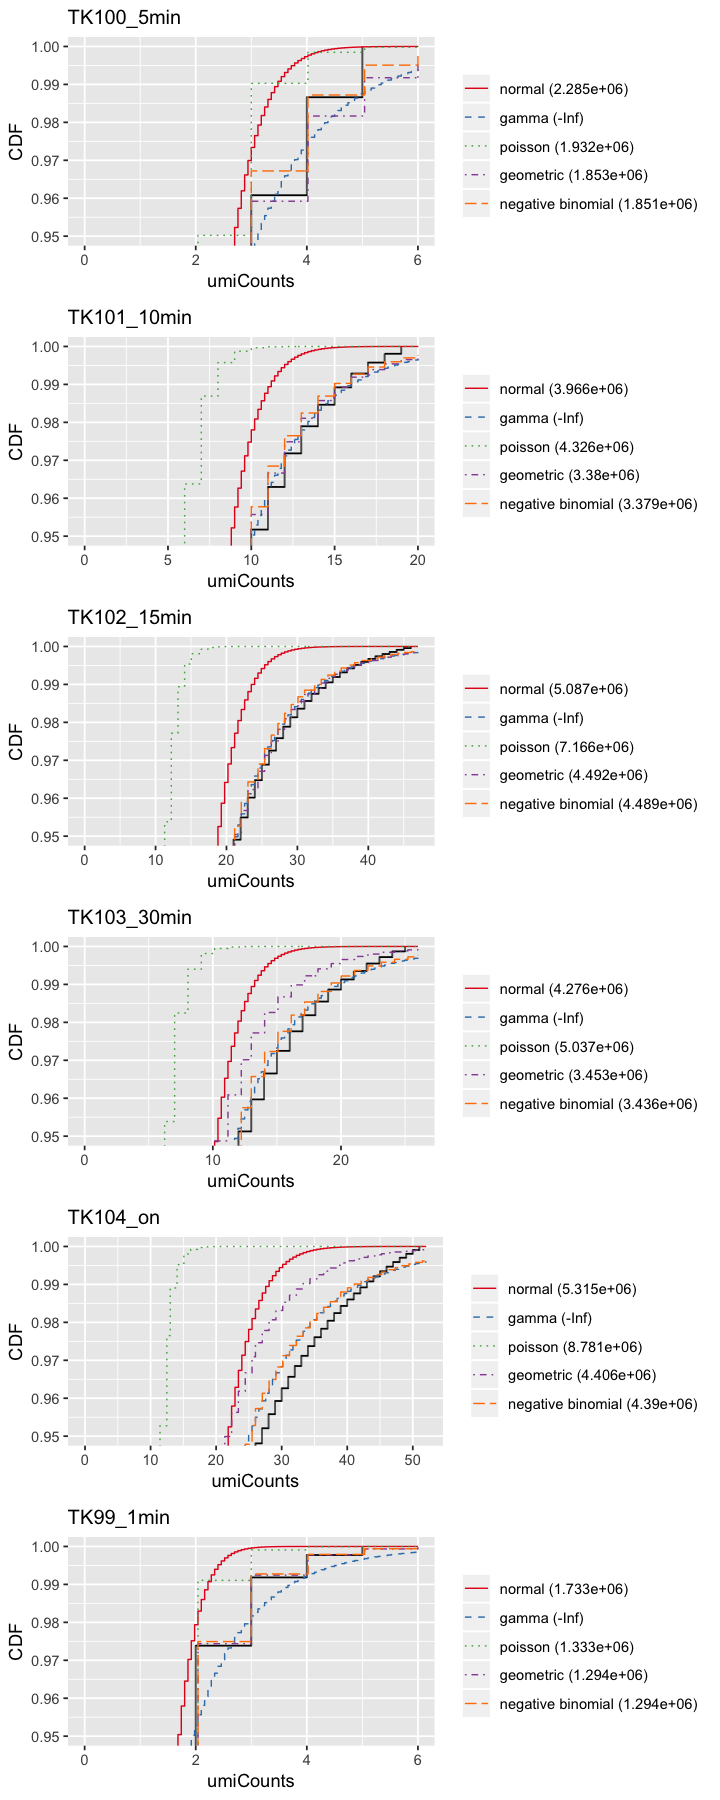

In [12]:
options(repr.plot.width=6, repr.plot.height=15)
p <- grid.arrange(grobs=myplots, nrow=6)

## Summary
- The UMI counts best fit a negative binomial or a gamma.  
- Use the gamma in the HMM because it is continuous and because the depmix has a Gamma option, but not a neg binomial option 

# Testing HMM using a gamma model 
- I want to find states of the UMI counts across multiple time points.
- I tried modelling each time point as a combination of two gamma distributions, one with an average equal to the average of the data, and one with an average at the 99.9 quantile value. Then I try to detect these two states with an HMM. 

In [13]:
library(depmixS4)
library(fitdistrplus)

In [14]:
dat58 <- read.table("data/BICRO58_all_umiCount.txt", header=T)
dat58 <- dat58[c(1:3,5:nrow(dat58)),]  # remove this weird super outlier point

In [15]:
dat58[1:3,]

chr,start,end,cs_id,TK100_5min,TK101_10min,TK102_15min,TK103_30min,TK104_on,TK99_1min
chr1,237070,237076,cs_237076,-1,-1,-1,-1,1,-1
chr1,238784,238790,cs_238790,-1,-1,2,-1,-1,-1
chr1,247333,247339,cs_247339,-1,1,-1,-1,-1,-1


In [16]:
datcnts <- dat58[,c(10,5:9)]
datcnts[datcnts < 0]=0
mytimes <- c("min1", "min5", "min10", "min15", "min30", "on")
colnames(datcnts) <- mytimes
datcnts <- datcnts +0.2 # add a pseudocount to avoid zeros

In [17]:
# Just test this on a small chromosome
testdat <- datcnts[dat58$chr=="chr22",]

In [18]:
# Try making an hmm of one of the counts with 2 states
mu <- mean(testdat$min1)
q99 <- quantile(testdat$min1, .999)[[1]]
mu
q99
mod <- depmix(list(min1~1), data=testdat, nstates=2, family=list(Gamma()), respstart=c(mu, q99))
fmod <- fit(mod)
summary(fmod)

[1] 0.5827928

[1] 7.2

Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”

iteration 0 logLik: -3798.798 
iteration 5 logLik: -3798.036 
iteration 10 logLik: -3798.026 
converged at iteration 12 with logLik: -3798.026 
Initial state probabilties model 
pr1 pr2 
0.5 0.5 

Transition matrix 
        toS1  toS2
fromS1 0.511 0.489
fromS2 0.511 0.489

Response parameters 
Resp 1 : Gamma 
    Re1.(Intercept)
St1           1.716
St2           1.716


- I get an error when I do this for time points greater than 1 min.
- The HMM from the 1 min time point with two states generates two almost identical states (see the Response parameters above).  This is not very useful. Essentially, while I'm trying to force the HMM to detect two different gamma distributions, the data really just fits one, so the HMM fails to find two distinct states. 
- A better strategy may be to model each time point as a multinomial, dividing them into "Low", "medium", and "high" categories. This forces each timepoint into three different states. 

# HMM with multinomial

In [19]:
library(depmixS4)

In [20]:
dat58 <- read.table("data/BICRO58_all_umiCount.txt", header=T)
dat58 <- dat58[c(1:3,5:nrow(dat58)),]  # remove this weird super outlier point

In [21]:
datcnts <- dat58[,c(10,5:9)]
datcnts[datcnts < 0]=0
mytimes <- c("min1", "min5", "min10", "min15", "min30", "on")
colnames(datcnts) <- mytimes


In [22]:
# again, test on chr22 only
ci=dat58$chr=="chr22"

## Model 1
- Here I'm using three states, the bottom 90% of each time point, the top 10, and the top 1% as the three different states for each time point.  
- I'm only modeling 1 min, 5min, and 10 min. 

In [23]:
## Change the counts into quantiles. 
myquantiles=c(.9,.99)
datqnt <- datcnts
for (j in seq(1:ncol(datcnts))){
    qvals <- c(-1, quantile(datcnts[,j], c(myquantiles, 1)))
    for (i in seq(1,(length(qvals) -1))){
        xi <- (datcnts[,j] > qvals[[i]]) & (datcnts[,j] <= qvals[[i+1]])
        datqnt[xi,j] <- i
    }
}

In [24]:
## Function for creating the depmix models
make_depmix_model_df <- function(mydata, nstates=2, verbose=F){
    # Fit the model
    mod <- depmix(list(min1~1, min5~1, min10~1), data=mydata, nstates=nstates, 
              family=list(multinomial("identity"), multinomial("identity"), multinomial("identity")))
    fmod <- fit(mod, verbose=verbose)
    
    # Get the state data in a data frame
    resp <- fmod@response
    respdf <- data.frame(probs=NULL, timept=NULL, level=NULL, state=NULL)
    for (i in c(1:length(resp))){
        state <- resp[[i]]
        coef <- c()
        for (j in seq(1:length(state))){
            gm <- state[[j]]
            tpt <- as.character(gm@formula)[2]
            coef <- c(coef, gm@parameters$coefficients)
            respdf <- rbind(respdf, 
                data.frame(probs=coef, timept=tpt, level=as.character(names(coef)), state=i))
        }   
    }
    # Change the labels for plotting
    respdf$mylevel=as.character(respdf$level)
    respdf$mylevel[respdf$level=="1"]="ML"
    respdf$mylevel[respdf$level=="2"]="H"
    respdf$mylevel[respdf$level=="3"]="VH"
    
    respdf$index=paste0(respdf$timept, "_", respdf$mylevel)
    return(list(respdf, fmod))
}
## Function for plotting the model states 
make_depmix_model_plot <- function(respdf, fmod){
    myylabels=seq(fmod@nstates)
    for (i in seq(fmod@nstates)){
        stateperc <- round(sum(fmod@posterior$state==i)/fmod@ntimes, digits=3)
        myylabels[i] <- paste0(i, "\n",stateperc)
    }
    myxlimits=c("min1_ML", "min5_ML", "min10_ML", 
           "min1_H", "min5_H", "min10_H", 
           "min1_VH", "min5_VH", "min10_VH")
    p <- ggplot(data=respdf, aes(x=index, y=state)) + 
        geom_tile(aes(fill=probs)) + 
        scale_y_discrete("State", limits=seq(fmod@nstates), labels=myylabels) + 
        scale_x_discrete("Peak Category", limits=myxlimits) + 
        theme(axis.text.x = element_text(angle = 90, hjust=1)) + 
        labs(title=paste0("Model with ", fmod@nstates, " States"), subtitle=paste0("loglike: ", round(logLik(fmod), digits=0))) 
    return(p)
}

In [25]:
m2 <- make_depmix_model_df(mydata=datqnt[ci,], nstates=2)

converged at iteration 235 with logLik: -4840.836 


In [26]:
m3 <- make_depmix_model_df(mydata=datqnt[ci,], nstates=3)

In [27]:
m4 <- make_depmix_model_df(mydata=datqnt[ci,], nstates=4)

In [28]:
m5 <- make_depmix_model_df(mydata=datqnt[ci,], nstates=5)

In [29]:
p2 <-make_depmix_model_plot(m2[[1]], m2[[2]])
p3 <-make_depmix_model_plot(m3[[1]], m3[[2]])
p4 <-make_depmix_model_plot(m4[[1]], m4[[2]])
p5 <-make_depmix_model_plot(m5[[1]], m5[[2]])

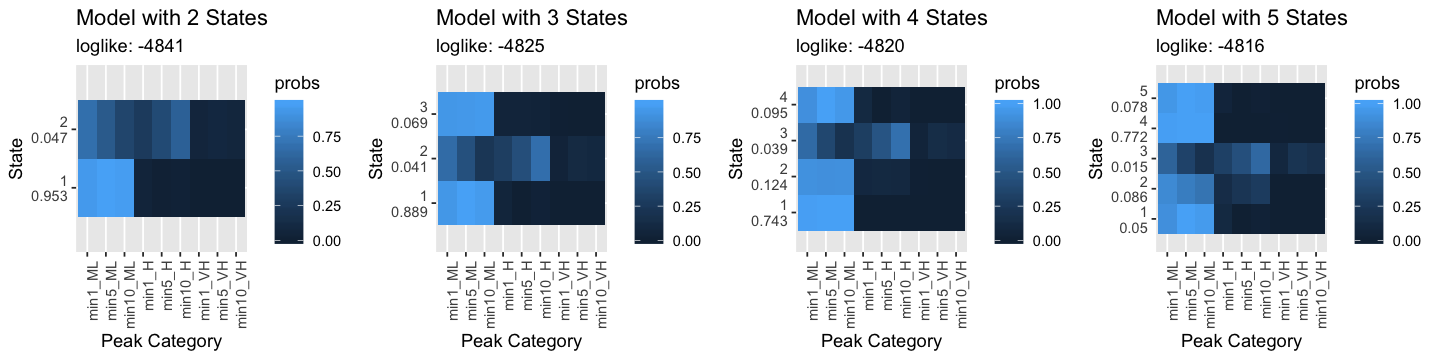

In [30]:
options(repr.plot.height=3, repr.plot.width=12)
grid.arrange(grobs=list(p2, p3, p4, p5), ncol=4)

Here are the probabilities of each peak category in each state.  A higher probability means that a cutsite in that state is more likely to be in a certain peak category.  The numbers below the state labels on the y axis are the fraction of cutsites on chr22 in that state. Note that the models with 3,4, and 5 states do not converge (default is 500 maximum iterations).

## Model 2 of whole genome
- I used 0.75, 0.90, 0.99 quantiles, labeled L, M, H, and VH. 
- Used the 5, 10, 15, and 30 minute time points
- I created these models on the cluster because whole genome analysis requires more compute power. I load the resulting R object for visualization. 

In [34]:
## Function for creating a dataframe for plotting from the depmix fitted model. 
make_depmix_model_df <- function(fmod, qlabels){
    # Get the state data in a data frame
    resp <- fmod@response
    respdf <- data.frame(probs=NULL, timept=NULL, level=NULL, state=NULL)
    for (i in c(1:length(resp))){
        state <- resp[[i]]
        coef <- c()
        for (j in seq(1:length(state))){
            gm <- state[[j]]
            tpt <- as.character(gm@formula)[2]
            coef <- c(coef, gm@parameters$coefficients)
            respdf <- rbind(respdf, 
                data.frame(probs=coef, timept=tpt, level=as.character(names(coef)), state=i))
        }   
    }
    stopifnot(length(qlabels)==length(gm@parameters$coefficients))
    # Change the labels for plotting
    respdf$mylevel=as.character(respdf$level)
    respdf$level=as.numeric(respdf$level)
    for (i in seq(1,length(qlabels))){
        respdf$mylevel[respdf$level==i]=qlabels[i]
    }
    respdf$index=paste0(respdf$timept, "_", respdf$mylevel)
    return(respdf)
}

## Function for plotting the model states 
make_depmix_model_plot <- function(respdf, fmod, myxlimits){
    myylabels=seq(fmod@nstates)
    for (i in seq(fmod@nstates)){
        stateperc <- round(sum(fmod@posterior$state==i)/sum(fmod@ntimes), digits=3)
        myylabels[i] <- paste0(i, " (",stateperc, ")")
    }
    p <- ggplot(data=respdf, aes(x=index, y=state)) + 
        geom_tile(aes(fill=probs)) + 
        scale_y_discrete("State", limits=seq(fmod@nstates), labels=myylabels) + 
        scale_x_discrete("Peak Category", limits=myxlimits) + 
        theme(axis.text.x = element_text(angle = 90, hjust=1)) + 
        labs(title=paste0("Model with ", fmod@nstates, " States"), subtitle=paste0("loglike: ", round(logLik(fmod), digits=0), "\nBIC: ", round(BIC(fmod), digits=0))) 
    return(p)
}


In [37]:
myplots = c()
myxlimits=c("min5_L", "min10_L", "min15_L", "min30_L", 
                "min5_M", "min10_M", "min15_M", "min30_M",
                "min5_H", "min10_H", "min15_H", "min30_H", 
                "min5_VH", "min10_VH", "min15_VH", "min30_VH")
for (i in seq(4,7)){
    load(paste0("depmix_results/bicro58_m1s", i, "_fmod.rdf"))
    df <- make_depmix_model_df(fmod, qlabels=c("L", "M", "H", "VH"))
    p <- make_depmix_model_plot(df, fmod, myxlimits=myxlimits)
    rm(fmod, df)
    myplots <- c(myplots, list(p))
}

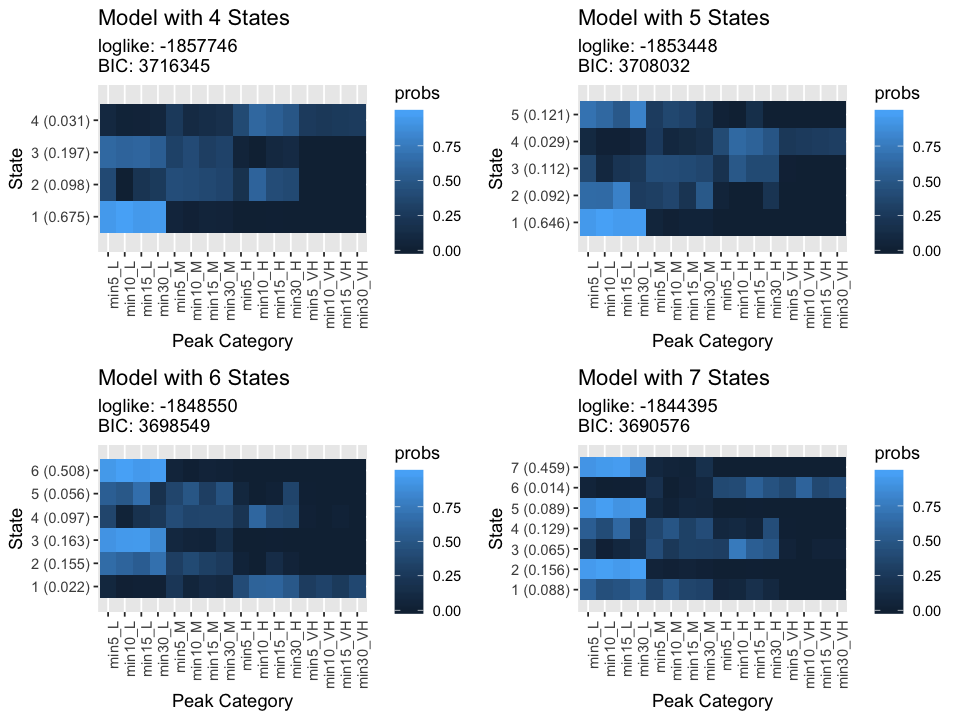

In [38]:
options(repr.plot.height=6, repr.plot.width=8)
g <- grid.arrange(grobs=myplots, ncol=2)

In [40]:
ggsave(file="depmix_wg_models4-7.png", path=figdir, plot=g, width=8, height=6, units="in")

In [42]:
myplots = c()
myxlimits=c("min5_L", "min10_L", "min15_L", "min30_L", 
                "min5_M", "min10_M", "min15_M", "min30_M",
                "min5_H", "min10_H", "min15_H", "min30_H", 
                "min5_VH", "min10_VH", "min15_VH", "min30_VH")
for (i in seq(8,9)){
    load(paste0("depmix_results/bicro58_m1s", i, "_fmod.rdf"))
    df <- make_depmix_model_df(fmod, qlabels=c("L", "M", "H", "VH"))
    p <- make_depmix_model_plot(df, fmod, myxlimits=myxlimits)
    rm(fmod, df)
    myplots <- c(myplots, list(p))
}

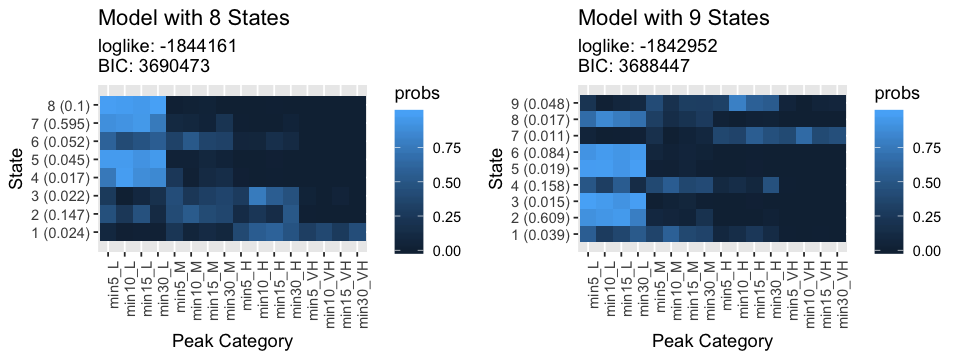

In [43]:
options(repr.plot.height=3, repr.plot.width=8)
g2 <- grid.arrange(grobs=myplots, ncol=2)

In [44]:
ggsave(file="depmix_wg_models8-9.png", path=figdir, plot=g2, width=8, height=3, units="in")

Here, again, the probabilities represent the probability of each peak category in each state.  The numbers in parenthesis on the y axis are the fraction of cutsites in that state.

The models with greater than 5 states are probably over segmented because multiple states look very similar.  For example, in the 9 state model, states 2,3,5, and 6 look very similar.  Interesting states would be ones in which there is a difference over the timepoints, for example, state 1,4, or 7.  The plots below may make this more intuitive to interpret.  

# HMM states with average UMI and centrality

- plot the average number of cutsites per time point for the various states.  How different are they? 

In [45]:
load("depmix_results/bicro58_m1s9_fmod.rdf")
poststate <- fmod@posterior$state
dat58 <- read.table("data/BICRO58_all_umiCount2.txt", header=T)

In [46]:
datcnts <- dat58[,5:8]
datcnts[datcnts < 0]=0

# Normalize by the total number of reads
tots <- apply(datcnts, 2, sum)
datf <- t(t(datcnts)/tots) * 1e6
myslabels=seq(1, fmod@nstates)
aveumi <- matrix(nrow=fmod@nstates, ncol=ncol(datf))
for (i in seq(1,fmod@nstates)){
    stateperc <- round(sum(fmod@posterior$state==i)/sum(fmod@ntimes), digits=3)
    myslabels[i] <- paste0(i, ": ",stateperc*100, "%")
    for (j in seq(1,ncol(datf))){
        aveumi[i,j] = mean(datf[poststate==i,j])
    }
}
colnames(aveumi) <- c("min5", "min10", "min15", "min30")
df <- data.frame(aveumi)
df$state <- seq(1,9)
dfm <- melt(df, id.vars=c("state"))

In [47]:
pumi1 <- ggplot(dfm, aes(x=state, y=value, color=variable)) + geom_point() + 
    scale_x_discrete(limits=seq(1,9),  labels=myslabels) + 
    theme(axis.text.x = element_text(angle = 90, hjust=1)) + 
    ylim(0,3) #+ scale_color_manual(values=brewer.pal(9, "Blues")[5:9])

In [50]:
pumi <- ggplot(dfm, aes(x=state, y=value, color=variable)) + geom_point() + 
    scale_x_discrete(limits=seq(1,9),  labels=myslabels) + 
    theme(axis.text.x = element_text(angle = 90, hjust=1)) + labs(y="Average normalized UMI", col="timepoint")

## Average UMI per state

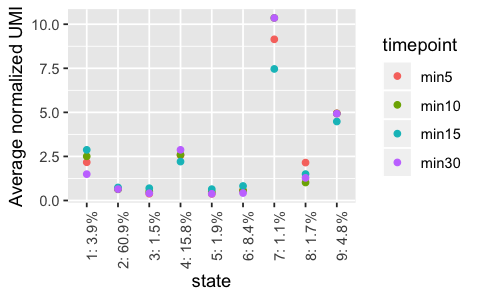

In [51]:
options(repr.plot.height=2.5, repr.plot.width=4)
g <- grid.arrange(pumi)
ggsave(file="umi_per_state.png", path=figdir, plot=g, width=4, height=2.5, units="in")

Very few of the states show an increase over the time points in relative UMI.  It would be worth exploring this further because the 15 minute timepoint doesn't seem to "fit" in order when looking at other metrics, like coverage or the histograms.  This analysis could be done again, leaving out certain time points (5 min may be too noisy), and leaving in others, such as the over night data. Some of the states, particularly those with few points, such as state 3 and state 5, may just represent noise in the data.  By forcing the data into the L,M,H, and VH categories, we are introducing some noise.  Ie- a point may be on the edge of M/H and in one timepoint is called L while in another called H, and these "edge" classifications may result in their own states. 

## Average Centrality per state

In [52]:
# calculate the centrality for each cutsite using your estimate
difx <- apply(datf, 1, diff)
centr <- apply(difx, 2, sum)

In [53]:
avecent=c()
for (i in seq(1,fmod@nstates)){
    avecent = c(avecent, mean(centr[poststate==i], na.rm=T))
}

In [54]:
df <- data.frame(avecent)
p <- ggplot(df, aes(x=seq(1,9), y=avecent)) + geom_point() + 
    scale_x_discrete(limits=seq(1,9)) + labs(x="state", y="Average centrality") 

Warning message:
“Removed 8 rows containing missing values (geom_point).”

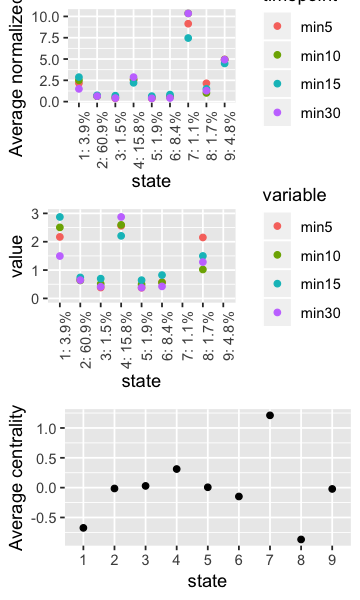

In [55]:
options(repr.plot.width=3, repr.plot.height=5)
grid.arrange(pumi, pumi1, p)

In [56]:
ggsave(file="centrality_per_state.png", path=figdir, plot=p, width=3, height=2, units="in")

The centrality seems to correspond to the UMI count, with high centrality in regions with UMI peaks across time points, and low centrality in regions with M or L UMI counts.  State 1 and 8 don't fit this mold, as they have low centrality and Mid-level UMI counts.  These might be regions to explore further.  

## Average Eigenvector values and GC content per state

In [57]:
hicdat <- read.table("data/BICRO58_all_umiCount2_kbm7hic_gc.txt", header=T)

In [58]:
avegc=c()
avehic=c()
for (i in seq(1,fmod@nstates)){
    avegc = c(avegc, mean(hicdat$gc[poststate==i], na.rm=T))
    avehic = c(avehic, mean(hicdat$hic_eigen[poststate==i], na.rm=T))
}

In [59]:
df <- data.frame(avegc)
pgc <- ggplot(df, aes(x=seq(1,9), y=avegc)) + geom_point() + 
    scale_x_discrete(limits=seq(1,9)) + labs(x="state", y="Average GC content") 

In [60]:
df <- data.frame(avehic)
phic <- ggplot(df, aes(x=seq(1,9), y=avehic)) + geom_point() + 
    scale_x_discrete(limits=seq(1,9)) + labs(x="state", y="Average Eigenvector values") 

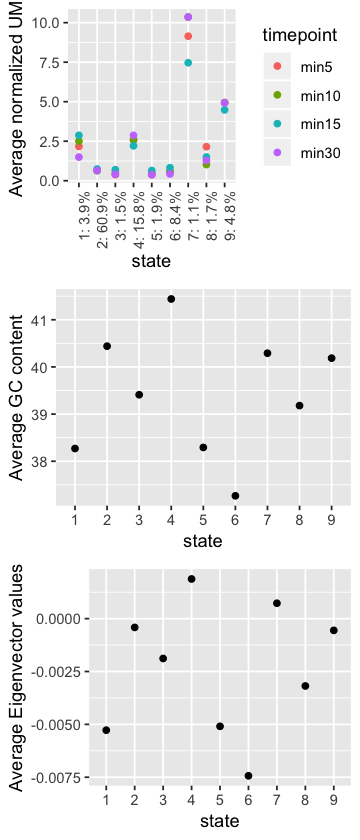

In [61]:
options(repr.plot.width=3, repr.plot.height=7)
grid.arrange(pumi, pgc, phic)

Both GC content and HiC compartmentalization show similar patterns and vary across the different states. They seem to show less correspondence to the average relative UMI values than centrality.  